# Taxonomic assignment: Downstream analyses

In [ ]:
# !pip install openpyxl
# !pip install venn

In [1]:
# load modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from venn import venn
from openpyxl.workbook import Workbook

/home/lubo/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load dataset function

def load_data(marker, cell, sim):
    # loading summary taxonomic assignment table into a dataframes
    raw_data="../raw_data"
    data_path=f"{raw_data}/OTU_summary_tables/otu_summary_table_{marker}_{cell}_{sim}.tsv"
    return pd.read_csv(data_path, sep="\t")

## Summary tables

In [3]:
# load the summary tables into sum_tables dictionary

sum_tables={"cell1_sim97": "", 
          "cell1_sim99": "", 
          "cell2_sim97": "", 
          "cell2_sim99": "",
          "cellCombined_sim97": "",
          "cellCombined_sim99": ""}


for dataset in sum_tables:
    cell, sim = dataset.split("_")
    sum_tables[dataset]=load_data("Full18S", cell, sim)

In [ ]:
# save all the summary table as excel tables
marker="Full18S"
data_path="../raw_data/OTU_summary_tables"

for dataset in sum_tables:
    cell, sim = dataset.split("_")
    sum_tables[dataset].to_excel(f"{data_path}/OTU_summary_table_{marker}_{cell}_{sim}.xlsx")

In [ ]:
samples=['A3', 'Mock', 'NH1', 'NH4', 'Sim17', 'Sim22', 'Th16', 'Th38',
       'Th40', 'X17007']

# creating a dictonary with sample names where we will store abundance information for each sample
abundance = {}
for sample in samples:
    abundance[sample] = []

# loop through each dataset and calculate number of unique OTUs for each sample
for dataset in sum_tables:
    for sample_name in samples:
        abundance[f'{sample_name}'].append(len(sum_tables[dataset][sum_tables[dataset][f'{sample_name}'] != 0]))
    
unique_otus = pd.DataFrame(data=abundance, index=sum_tables.keys())
unique_otus

In [ ]:
# number of unique OTUs for all samples together
unique_otus["total"] = unique_otus.iloc[0:9].sum(axis=1)
unique_otus

## Venn diagrams

We want to determine how many OTUs are unique for each dataset (cell1, cell2, and cellCombined), and how many OTUs are shared between the datasets. We will do it for datasets with OTUs created based on 97 and 99 similarity percentage separatelly.

In [ ]:
# create a dataset name column for each dataset dataframe

for dataset in sum_tables:
    sum_tables[dataset]["dataset"]=f"{dataset}"

In [ ]:
# list of your dataframes
pd_list_97=[sum_tables["cell1_sim97"], sum_tables["cell2_sim97"], sum_tables["cellCombined_sim97"]]
pd_list_99=[sum_tables["cell1_sim99"], sum_tables["cell2_sim99"], sum_tables["cellCombined_sim99"]]

# for dataset in sum_tables:
#     pd_list.append(sum_tables[dataset])

In [ ]:
venn_df_97 = pd.concat(pd_list_97)
venn_df_99 = pd.concat(pd_list_99)

In [ ]:
# first we need to get the otu table with the occurrence of each biome
otu_cooccurance_97 = pd.crosstab(venn_df_97["ID"], venn_df_97["dataset"]).gt(0).astype(int)
otu_cooccurance_99 = pd.crosstab(venn_df_99["ID"], venn_df_99["dataset"]).gt(0).astype(int)

In [ ]:
# now it's ease to find out any combination of the shared OTUs between datasets
# 0 means the OTU is not present and 1 means OTU is present in the given dataset
# if we set one for each dataset, we will filtrate only the unique OTUs that occured in all datasets 

otu_alldatasets_97 = otu_cooccurance_97[(otu_cooccurance_97['cell1_sim97'] == 1) 
                                      & (otu_cooccurance_97['cell2_sim97'] == 1) 
                                      & (otu_cooccurance_97['cellCombined_sim97'] == 1)]

otu_alldatasets_99 = otu_cooccurance_99[(otu_cooccurance_99['cell1_sim99'] == 1) 
                                      & (otu_cooccurance_99['cell2_sim99'] == 1) 
                                      & (otu_cooccurance_99['cellCombined_sim99'] == 1)]

In [ ]:
otu_cooccurance_99['cell1_sim99']

In [ ]:
# creating dataset for the venn diagram
venn_datasets_97={}

venn_datasets_97["cell1_sim97"] = set(venn_df_97[venn_df_97.dataset == "cell1_sim97"].to_dict('list')['ID'])
venn_datasets_97["cell2_sim97"] = set(venn_df_97[venn_df_97.dataset == "cell2_sim97"].to_dict('list')['ID'])
venn_datasets_97["cellCombined_sim97"] = set(venn_df_97[venn_df_97.dataset == "cellCombined_sim97"].to_dict('list')['ID'])

venn_datasets_99={}

venn_datasets_99["cell1_sim99"] = set(venn_df_99[venn_df_99.dataset == "cell1_sim99"].to_dict('list')['ID'])
venn_datasets_99["cell2_sim99"] = set(venn_df_99[venn_df_99.dataset == "cell2_sim99"].to_dict('list')['ID'])
venn_datasets_99["cellCombined_sim99"] = set(venn_df_99[venn_df_99.dataset == "cellCombined_sim99"].to_dict('list')['ID'])

In [ ]:
# venn diagram using the pyvenn library: https://pypi.org/project/venn/

from matplotlib.colors import ListedColormap

datasets=[venn_datasets_97, venn_datasets_99]
label=["97", "99"]
path="../raw_data/OTU_summary_tables"

for i in range(2):
    
    fig, ax1 = plt.subplots(figsize=(9, 9), nrows=1, ncols=1)

    c = venn(datasets[i], 
             alpha=0.5, 
             figsize=(10, 5), 
             fontsize=18, 
             legend_loc="upper right", 
             cmap=ListedColormap(["#CC79A7", "#009E73", "#0072B2"]), 
             ax=ax1)


    ax1.get_legend().remove()
    plt.text(0.26, # horizontal
             0.9, # vertical
             "Cell 1", 
             fontsize=25, color='#CC79A7')

    plt.text(
             0.62, # horizontal
             0.9, # vertical
             "Cell 2", 
             fontsize=25, color='#009E73')

    plt.text(
             0.32, # horizontal
             0, # vertical
             "Combined cells", 
             fontsize=25, color='#0072B2')

    # plt.show()

    # save
    plt.savefig(f"{path}/venn_datasets_{label[i]}.png", dpi=300, transparent=False)
    plt.savefig(f"{path}/venn_datasets_{label[i]}.pdf", dpi=300)


## Inspecting how abundances declined through the pipeline (per sample)

Changing number of features (reads, asvs, otus) through the pipeline
Steps in pipelines:
- raw reads
- denoise (filter, denoise, chimeric seqs)
- OTU custering
- otu filter.

### Denoise table

In [ ]:
raw_data="../raw_data"
datasets=["cell1", "cell2", "cellCombined"]

df_denoise={}

for dataset in datasets:
    df_denoise[dataset]=pd.read_csv(f"{raw_data}/denoise/Full18S/{dataset}/asv_stats.tsv", sep="\t")
    df_denoise[dataset]=df_denoise[dataset][["sample-id", "input", "primer-removed", "filtered", "denoised", "non-chimeric"]]
    df_denoise[dataset]=df_denoise[dataset].tail(-1)
    df_denoise[dataset]=df_denoise[dataset].rename(columns={"sample-id": "sample_id", "input": "raw_reads", "input": "raw_reads", "filtered": "asv_filtered"})
    id_splited=df_denoise[dataset]['sample_id'].str.split(pat="_", expand=True)
    df_denoise[dataset]["sample_id"]=id_splited[0]
    df_denoise[dataset]=df_denoise[dataset].set_index("sample_id")

In [ ]:
df_denoise["cellCombined"]

### OTU clustering table

In [ ]:
raw_data="../raw_data"
datasets=["cell1", "cell2", "cellCombined"]

df_otu={}

for dataset in datasets:
    df_otu[dataset]=pd.read_csv(f"{raw_data}/OTU_clust/Full18S/{dataset}/sim99/feature_count.tsv", sep="\t")
    id_splited=df_otu[dataset]['Sample_ID'].str.split(pat="_", expand=True)
    df_otu[dataset]['Sample_ID']=id_splited[0]
    df_otu[dataset]=df_otu[dataset].rename(columns={"Sample_ID": "sample_id", "Feature_Count": "otu_clustered"})
    df_otu[dataset]=df_otu[dataset].set_index("sample_id")

In [ ]:
df_otu["cellCombined"]

### OTU filtering table

In [ ]:
# changing number of features (reads, asvs, otus) through the pipeline
# steps in pipelines: raw reads, denoise, otu, otu filter

In [ ]:
raw_data="../raw_data"
datasets=["cell1", "cell2", "cellCombined"]

df_otu_filt={}

for dataset in datasets:
    df_otu_filt[dataset]=pd.read_csv(f"{raw_data}/OTU_filtered/Full18S/{dataset}/sim99/feature_count.tsv", sep="\t")
    id_splited=df_otu_filt[dataset]['Sample_ID'].str.split(pat="_", expand=True)
    df_otu_filt[dataset]['Sample_ID']=id_splited[0]
    df_otu_filt[dataset]=df_otu_filt[dataset].rename(columns={"Sample_ID": "sample_id", "Feature_Count": "otu_filt_sim99"})
    df_otu_filt[dataset]=df_otu_filt[dataset].set_index("sample_id")

In [ ]:
df_otu_filt["cellCombined"]

### Merging all tables together

In [ ]:
datasets=["cell1", "cell2", "cellCombined"]

df_abundances={}

for dataset in datasets:
    df_abundances[dataset]=df_denoise[dataset] \
    .merge(df_otu[dataset], left_index=True, right_index=True) \
    .merge(df_otu_filt[dataset], left_index=True, right_index=True)
    df_abundances[dataset]=df_abundances[dataset].astype(int)

In [ ]:
df_abundances["cellCombined"]

In [ ]:
# save the final table to an excel file

path="../raw_data/OTU_summary_tables"

with pd.ExcelWriter(f"{path}/abundances.xlsx") as writer:  
    df_abundances["cell1"].to_excel(writer, sheet_name="cell1")
    df_abundances["cell2"].to_excel(writer, sheet_name="cell2")
    df_abundances["cellCombined"].to_excel(writer, sheet_name="cellCombined")

## Inspecting how abundances declined through the pipeline (all samples together)

In [ ]:
datasets=["cell1", "cell2", "cellCombined"]

df_abundances_total={}

for dataset in datasets:
    df_abundances_total[dataset] = df_abundances[dataset].sum(axis=0).to_frame().reset_index()
    df_abundances_total[dataset] = df_abundances_total[dataset].rename(columns= {0: 'total'})

In [ ]:
df_abundances_total["cell1"]

In [ ]:
dataset="cell2"
path="../raw_data/OTU_summary_tables"



sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
abund_bar=sns.barplot(x="index", y="total", data=df_abundances_total[dataset], palette="rocket");
abund_bar.set(xlabel="", ylabel = "Abundance", title =f"Decline of abundances throughout the pipeline")
abund_bar.set_xticklabels(["Raw reads", 
                           "Primers\nfiltering", 
                           "Length\nfiltering", 
                           "ASV\ndenoised", 
                           "Chimeras\nremoved",
                           "OTU\nclustered",
                           "OTU\nfiltered"])
sns.despine()

# plt.savefig(f"{path}/abundance_{dataset}.png", dpi=300)

## Reducing number of representative sequences throughout the pipeline

We used three steps that reduce number of the features (representative sequences) in our pipeline:

1. **Denoising raw sequences:** primers and length filtering, denoising, chimeras filtering
2. **OTU clustering:** based on 97 and 99 similarity threshold
3. **OTU filtering:** filtering out taxonomically unassigned OTUs at phyllum level and filtering out rare OTUs

Let's check how many unique number of features was reduced during these three steps.

In [ ]:
datasets=["cell1", "cell2", "cellCombined"]
denoise_path="../raw_data/denoise/Full18S"
otu_clust_path="../raw_data/OTU_clust/Full18S"
otu_filt_path="../raw_data/OTU_filtered/Full18S"
sim="sim99"

# creating dictionary where we will append the values in the loop below for our table
rep_seqs_data={"denoised": [],
               "OTU_clustered": [],
               "OTU_filtered": []}

# gathering information for the table
for dataset in datasets:
    
    # gather the total number of unique ASVs
    with open(f"{denoise_path}/{dataset}/asv_seqs.fasta", 'r') as file:
        denoised_fasta = file.read()
    rep_seqs_data["denoised"].append(denoised_fasta.count(">"))
    
    # gather the total number of unique OTUs
    with open(f"{otu_clust_path}/{dataset}/{sim}/otu_seqs.fasta", 'r') as file:
        otu_clust_fasta = file.read()
    rep_seqs_data["OTU_clustered"].append(otu_clust_fasta.count(">"))
    
    # gather the total number of unique OTUs after filtering
    with open(f"{otu_filt_path}/{dataset}/{sim}/otu_seqs_filtered.fasta", 'r') as file:
        otu_filt_fasta = file.read()
    rep_seqs_data["OTU_filtered"].append(otu_filt_fasta.count(">"))
    

# creating the final table that we will populate with data gather in the loop above
rep_seqs=pd.DataFrame(data=rep_seqs_data, index=["cell1", "cell2", "cellCombined"])
rep_seqs

In [ ]:
# bar plot of decreasing unique representative sequences after individual steps in the pipeline
path="../raw_data/OTU_summary_tables"

# adjusting the data table for plotting
df_plot=rep_seqs.reset_index()
df_plot=df_plot.melt(id_vars=['index'], value_vars=['denoised', 'OTU_clustered', 'OTU_filtered'])

# plotting code
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
repseq_bar=sns.barplot(data=df_plot, x="variable", y="value", hue="index")
repseq_bar.set(xlabel="", 
                ylabel = "number of representative sequences", 
                title =f"")
repseq_bar.set_xticklabels(["ASV denoised", "OTU clustered", "OTU filtered"])
sns.despine()

# adjusting legend
h, l = repseq_bar.get_legend_handles_labels()
repseq_bar.legend(handles=h, 
                  labels=["Cell 1", "Cell 2", "Combined Cells"], 
                  title="Flow Cell", 
                  loc="upper right", 
                  frameon=False);

# save
plt.savefig(f"{path}/unique_representative_sequences.png", dpi=300)

## Vampyrella specific data

We want to:
- check how many vampyrellid taxa were found in individual samples and in total
- how clustering thresholds affect number of vampyrellid taxa in mock community
- how filtering rare OTUs affect number of vampyrellid taxa in mock community

We supposed to find five taxa (different species) in mock sample

### Vampyrellid ASVs, OTUs, and OTUs with filtered rare sequences out

In [126]:
# defining a few functions for loading data and adjusting datasets for plotting data

def read_into_dic(dictionary, input_dir, marker="Full18S"):
    """read tsv summary tables as dataframes and save them into a dictionary.
    Each dataframe will represent a key in the dictionary.
    Provide a dictionary with names of the datasets as input file in the following pattern:
    cell_sim. Also provide a path to the directory with the summary tables"""
    for dataset in dictionary:
        cell, sim = dataset.split("_")
        data_path=f"{input_dir}/otu_summary_table_{marker}_{cell}_{sim}.tsv"
        dictionary[dataset]=pd.read_csv(data_path, sep="\t")
    return dictionary

def filt_vamp(dataset_dict):
    """filtered only vampyrellida ASVs for each dataframe and 
    save it into new a dictionary"""
    vamp_spec_dict={}
    for dataset in dataset_dict.keys():
        vamp_spec_dict[dataset]=dataset_dict[dataset][dataset_dict[dataset]["Order"] == "Vampyrellida"]
    return vamp_spec_dict

def num_otus_allsample(vamp_spec_dict):
    """create a dataframe with total number of vampyrellid OTUs 
    found in each dataset for all samples combined"""
    data_for_table={"num_otus": []}
    for dataset in vamp_spec_dict.keys():
        data_for_table["num_otus"].append(vamp_spec_dict[dataset].shape[0])
    return pd.DataFrame(data=data_for_table, index=vamp_spec_dict.keys())

def num_otus_persample(samples, vamp_spec_dict):
    """create a dataframe with total number of vampyrellid OTUs 
    found in each dataset and each sample. Provide: i) list of samples,
    ii) dictionary with individual datasets."""
    data_for_table={"sample": [],
                    "num_otus": [], 
                    "dataset": []}
    for dataset in vamp_spec_dict.keys():
        current_dataset = vamp_spec_dict[dataset]
        for sample in samples:
            data_for_table["sample"].append(sample)
            individual_sample=current_dataset[current_dataset[sample] != 0]
            data_for_table["num_otus"].append(individual_sample.shape[0])
            data_for_table["dataset"].append(dataset)
    return pd.DataFrame(data=data_for_table)

In [172]:
# variables
input_dir_unfilt="../raw_data/OTU_summary_tables/unfiltered"

input_dir_filt="../raw_data/OTU_summary_tables"


samples=['A3', 'Mock', 'NH1', 'NH4', 'Sim17', 'Sim22', 'Th16', 'Th38', 'Th40', 'X17007']
datasets_filt={"cell1_sim97": "",
          "cell1_sim99": "", 
          "cell2_sim97": "", 
          "cell2_sim99": "",
          "cellCombined_sim97": "",
          "cellCombined_sim99": ""}

datasets_unfilt={"cell1_sim97": "",
          "cell1_sim99": "", 
          "cell2_sim97": "", 
          "cell2_sim99": "",
          "cellCombined_sim97": "",
          "cellCombined_sim99": ""}


# load summary tables as dataframes
sum_tables_filt = read_into_dic(dictionary=datasets_filt, input_dir=input_dir_filt)

sum_tables_unfilt = read_into_dic(dictionary=datasets_unfilt, input_dir=input_dir_unfilt)


# retrain only vampyrellida ASVs
vamp_filt = filt_vamp(sum_tables_filt)
vamp_unfilt = filt_vamp(sum_tables_unfilt)


# creating table with total number of vampyrellid OTUs found in each dataset and all samples combined   
vamp_filt_allsamples=num_otus_allsample(vamp_filt)
vamp_unfilt_allsamples=num_otus_allsample(vamp_unfilt)

# creating a table with total number of vampyrellid OTUs found in each sample and each dataset
vamp_filt_persample = num_otus_persample(vamp_spec_dict=vamp_filt, samples=samples)
vamp_unfilt_persample = num_otus_persample(vamp_spec_dict=vamp_unfilt, samples=samples)

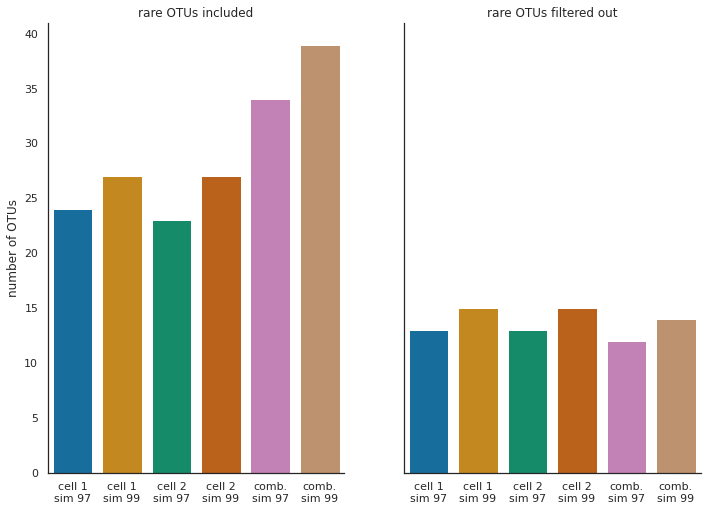

In [194]:
# plotting all sample combined results

path="../raw_data/OTU_summary_tables"
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11.7,8.27))
sns.set_style("white")

# vamp unfilt allsamples
vamp_unfilt_plot=sns.barplot(ax=axes[0], x=vamp_unfilt_allsamples.index, 
                            y="num_otus", 
                            data=vamp_unfilt_allsamples, 
                            palette="colorblind")
axes[0].set_title("rare OTUs included")

# vamp filt allsamples
vamp_filt_plot=sns.barplot(ax=axes[1], x=vamp_filt_allsamples.index, 
                            y="num_otus", 
                            data=vamp_filt_allsamples, 
                            palette="colorblind")
axes[1].set_title("rare OTUs filtered out")

vamp_filt_plot.set_xticklabels(["cell 1\nsim 97",
                                 "cell 1\nsim 99",
                                 "cell 2\nsim 97",
                                 "cell 2\nsim 99",
                                 "comb.\nsim 97",
                                 "comb.\nsim 99"])

vamp_unfilt_plot.set(xlabel="", ylabel = "number of OTUs")
vamp_filt_plot.set(xlabel="", ylabel = "")
sns.despine()

plt.savefig(f"{path}/number_of_vamp_otus_allsamples.png", dpi=300)

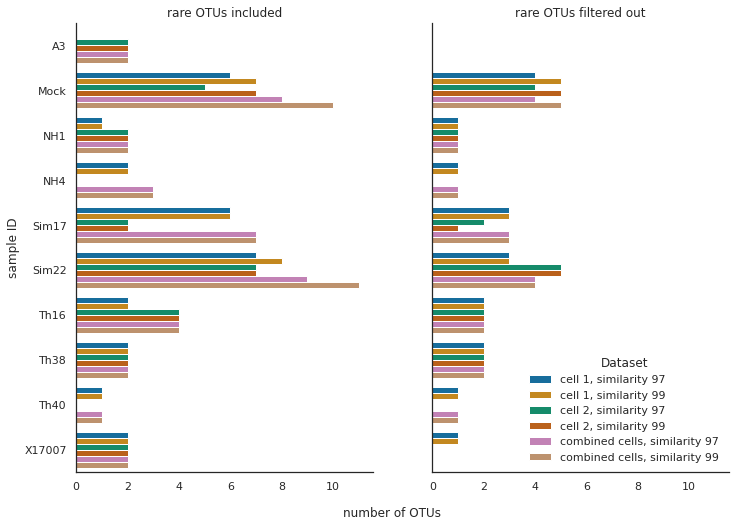

In [231]:
# plotting per sample results

path="../raw_data/OTU_summary_tables"
dataset_labels=["cell 1, similarity 97",
                "cell 1, similarity 99",
                "cell 2, similarity 97",
                "cell 2, similarity 99",
                "combined cells, similarity 97",
                "combined cells, similarity 99"]


fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11.7,8.27))
sns.set_style("white")

# vamp unfilt allsamples
vamp_unfilt_plot=sns.barplot(ax=axes[0], data=vamp_unfilt_persample,
                                y="sample",
                                x="num_otus",
                                hue="dataset",
                                palette="colorblind")
axes[0].set_title("rare OTUs included")

# vamp filt allsamples
vamp_filt_plot=sns.barplot(ax=axes[1], data=vamp_filt_persample,
                                y="sample",
                                x="num_otus",
                                hue="dataset",
                                palette="colorblind")
axes[1].set_title("rare OTUs filtered out")



# adjusting legend
h, l = vamp_persample_plot.get_legend_handles_labels()
vamp_filt_plot.legend(handles=h, 
                           labels=dataset_labels, 
                           title="Dataset", 
                           loc='lower right', 
                           frameon=False);

vamp_unfilt_plot.legend([],[], frameon=False)

vamp_unfilt_plot.set(xlabel="", ylabel="sample ID")
vamp_filt_plot.set(xlabel="", ylabel = "")


fig.text(0.5, 0.05, 'number of OTUs', ha='center')

sns.despine()

plt.savefig(f"{path}/number_of_vamp_otus_persample.png", dpi=300)

### Vampyrellids after filtering rare OTUs out

In [37]:
# creating vampyrellida specific ASVs dataframes from tsv summary tables  

# read tsv summary tables into sum_tables dictionary as individual dataframes
sum_tables={"cell1_sim97": "", 
            "cell1_sim99": "", 
            "cell2_sim97": "", 
            "cell2_sim99": "",
            "cellCombined_sim97": "",
            "cellCombined_sim99": ""}

for dataset in sum_tables:
    cell, sim = dataset.split("_")
    sum_tables[dataset]=load_data("Full18S", cell, sim)


# we will filtered only vampyrellida ASVs for each dataframe and save it into new df_vamp_filt dictionary
df_vamp_filt={}

for dataset in sum_tables.keys():
    df_vamp_filt[dataset]= sum_tables[dataset][sum_tables[dataset]["Order"] == "Vampyrellida"]

In [72]:
# check how many vampyrellid taxa were found in all samples combined and across the individual datasets

# creating table with total number of vampyrellid OTUs found in each dataset

data_for_table={"num_otus": []}

for dataset in df_vamp_filt.keys():
    data_for_table["num_otus"].append(df_vamp_filt[dataset].shape[0])
    
df_vamp_allsamples=pd.DataFrame(data=data_for_table, index=df_vamp_filt.keys())

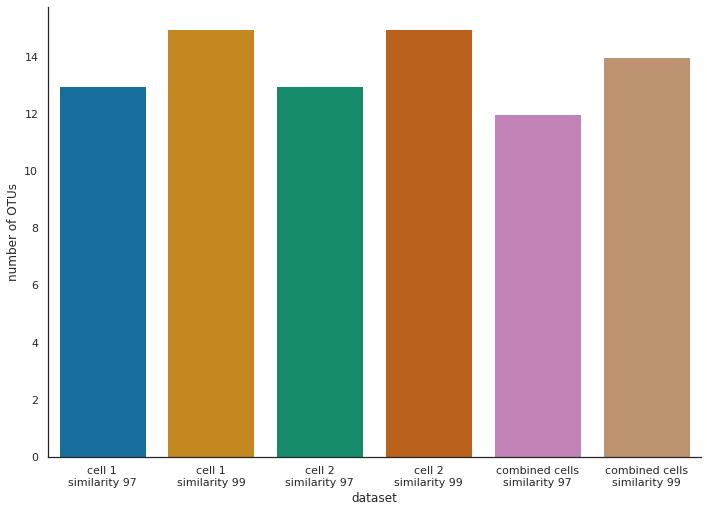

In [73]:
# plotting 
path="../raw_data/OTU_summary_tables"

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
vamp_allsamples=sns.barplot(x=df_vamp_allsamples.index, 
                            y="num_otus", 
                            data=df_vamp_allsamples, 
                            palette="colorblind")
vamp_allsamples.set_xticklabels(["cell 1\nsimilarity 97",
                                 "cell 1\nsimilarity 99",
                                 "cell 2\nsimilarity 97",
                                 "cell 2\nsimilarity 99",
                                 "combined cells\nsimilarity 97",
                                 "combined cells\nsimilarity 99"])


vamp_allsamples.set(xlabel="dataset", ylabel = "number of OTUs")


sns.despine()

plt.savefig(f"{path}/number_of_otus_allsamples.png", dpi=300)

In [80]:
# check how many vampyrellid taxa were found per sample and across the individual datasets

# creating a table with total number of vampyrellid OTUs found in each sample and each dataset

data_for_table={"sample": [],
                "num_otus": [], 
                "dataset": []}

samples=['A3', 'Mock', 'NH1', 'NH4', 'Sim17', 'Sim22', 'Th16', 'Th38', 'Th40', 'X17007']

for dataset in df_vamp_filt.keys():
    current_dataset = df_vamp_filt[dataset]
    for sample in samples:
        data_for_table["sample"].append(sample)
        individual_sample=current_dataset[current_dataset[sample] != 0]
        data_for_table["num_otus"].append(individual_sample.shape[0])
        data_for_table["dataset"].append(dataset)

    
df_vamp_persample=pd.DataFrame(data=data_for_table)

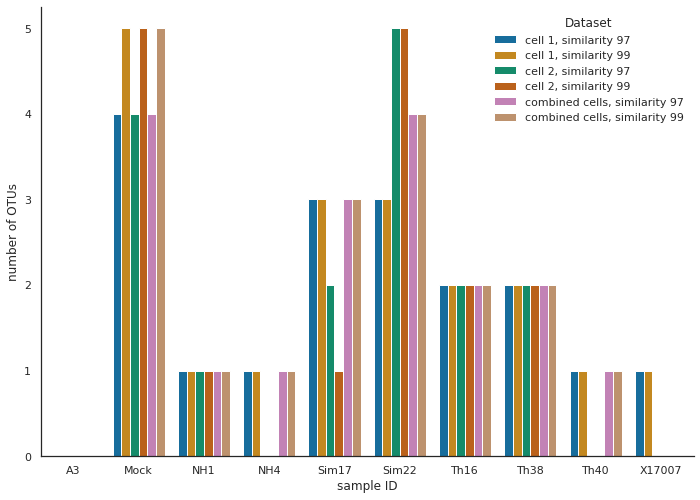

In [92]:
# plotting

dataset_labels=["cell 1, similarity 97",
                "cell 1, similarity 99",
                "cell 2, similarity 97",
                "cell 2, similarity 99",
                "combined cells, similarity 97",
                "combined cells, similarity 99"]


sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
vamp_persample=sns.barplot(data=df_vamp_persample,
                           x="sample",
                           y="num_otus",
                           hue="dataset",
                           palette="colorblind")

# adjusting legend
h, l = vamp_persample.get_legend_handles_labels()
vamp_persample.legend(handles=h, 
                  labels=dataset_labels, 
                  title="Dataset", 
                  loc='upper right', 
                  frameon=False);

vamp_persample.set(xlabel="sample ID", ylabel = "number of OTUs")
sns.despine()

plt.savefig(f"{path}/number_of_otus_persample.png", dpi=300)

## Similarity of the vampyrellid ASV sequences